                         Time  Execution Time
0  2024-05-18 18:34:07.252371        1.539244
1  2024-05-18 18:34:08.252371        1.981607
2  2024-05-18 18:34:09.252371        1.147822
3  2024-05-18 18:34:10.252371        2.687089
4  2024-05-18 18:34:11.252371        1.660926
5  2024-05-18 18:34:12.252371        0.355759
6  2024-05-18 18:34:13.252371        2.304723
7  2024-05-18 18:34:14.252371        2.180846
8  2024-05-18 18:34:15.252371        1.591539
9  2024-05-18 18:34:16.252371        2.671762
10 2024-05-18 18:34:17.252371        2.645529
11 2024-05-18 18:34:18.252371        2.668109
12 2024-05-18 18:34:19.252371        2.398825
13 2024-05-18 18:34:20.252371        1.543176
14 2024-05-18 18:34:21.252371        2.714736
15 2024-05-18 18:34:22.252371        0.897377
16 2024-05-18 18:34:23.252371        2.890530
17 2024-05-18 18:34:24.252371        1.990630
18 2024-05-18 18:34:25.252371        0.792971
19 2024-05-18 18:34:26.252371        1.610183
Përpunimi i të dhënave...
Përpunim

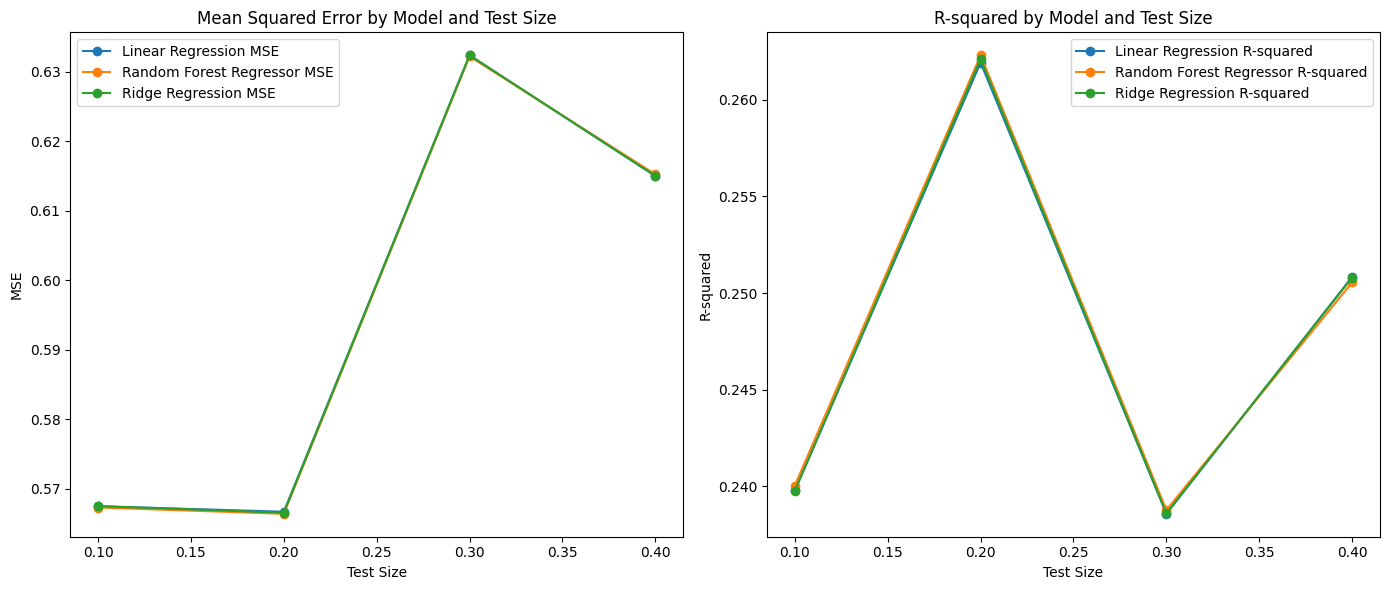

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Function to generate random data
def generate_random_data(num_rows=15000):
    # Generate a list of timestamps
    start_time = datetime.now()
    timestamps = [start_time + timedelta(seconds=i) for i in range(num_rows)]
    
    # Generate random execution times (let's assume they range between 0.1 and 3.0 seconds)
    execution_times = np.random.uniform(low=0.1, high=3.0, size=num_rows)
    
    # Create a DataFrame
    data = pd.DataFrame({
        'Time': timestamps,
        'Execution Time': execution_times
    })
    
    return data

# Generate the new random data
random_data = generate_random_data()

print(random_data.head(20))

# Load the existing datasets
df_macbook_pro1 = pd.read_csv('../datasets/MacBookPro1.csv')
df_macbook_pro2 = pd.read_csv('../datasets//MacBookPro2.csv')
df_raspberry_pi = pd.read_csv('../datasets//RaspberryPi.csv')
df_vm = pd.read_csv('../datasets//VM.csv')

# Add the generated random data to the existing datasets
datasets = [df_macbook_pro1, df_macbook_pro2, df_raspberry_pi, df_vm, random_data]
server_names = ['MacBookPro1', 'MacBookPro2', 'RaspberryPi', 'VM', 'GeneratedData']

print("Përpunimi i të dhënave...")
for i, df in enumerate(datasets):
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy="most_frequent")

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col].dtype):
            df[col] = numeric_imputer.fit_transform(df[[col]])
        elif pd.api.types.is_object_dtype(df[col].dtype):
            df[col] = categorical_imputer.fit_transform(df[[col]])

    df['Hour'] = df['Time'].dt.hour
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df['ServerType'] = server_names[i]

df_combined = pd.concat(datasets).reset_index(drop=True)
df_combined = pd.get_dummies(df_combined, columns=['ServerType'])
df_combined.drop('Time', axis=1, inplace=True)

print("Përpunimi i të dhënave përfundoi.")

final_imputer = SimpleImputer(strategy='median')
df_combined = pd.DataFrame(final_imputer.fit_transform(df_combined), columns=df_combined.columns)

X = df_combined.drop(['Execution Time'], axis=1)
y = df_combined['Execution Time']

split_ratios = [0.1, 0.2, 0.3, 0.4]
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0)
}

# Përgatitja e të dhënave për vizualizim
mse_results = {name: [] for name in models.keys()}
r2_results = {name: [] for name in models.keys()}

# Testimi me train-test splits të ndryshme
for test_size in split_ratios:
    print("\nTestimi me test size:", test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_results[name].append(mse)
        r2_results[name].append(r2)
        print(f"{name} - MSE: {mse}, R-squared: {r2}")

# Vizualizimi i rezultateve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
for name in models:
    ax1.plot(split_ratios, mse_results[name], marker='o', label=f'{name} MSE')
    ax2.plot(split_ratios, r2_results[name], marker='o', label=f'{name} R-squared')

ax1.set_title('Mean Squared Error by Model and Test Size')
ax1.set_xlabel('Test Size')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.set_title('R-squared by Model and Test Size')
ax2.set_xlabel('Test Size')
ax2.set_ylabel('R-squared')
ax2.legend()

plt.tight_layout()
plt.show()
